# NBA Projections Documentation

Because there is no current active NBA season, all of our model performance evaluation is based off of cross validation, and evaluation on a held out test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")
import pickle
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix

In [2]:
df = pd.read_csv("compare.csv")

In [3]:
# split data for testing
X = df.drop(["home_win"], axis=1)
y = df.home_win.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# import trained model, save predictor variable
model = pickle.load(open('model.pkl','rb'))
y_pred = model.predict(X_test)

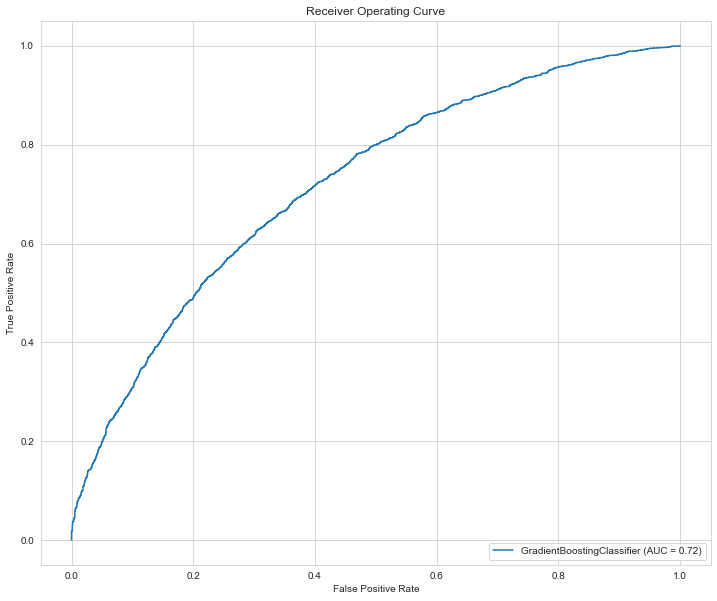

In [5]:
# plot and save ROC
fig, ax = plt.subplots(figsize=(12,10))
_ = plot_roc_curve(model,X_test,y_test, ax=ax)
_ = plt.title("Receiver Operating Curve")
_ = plt.savefig("roc.png")

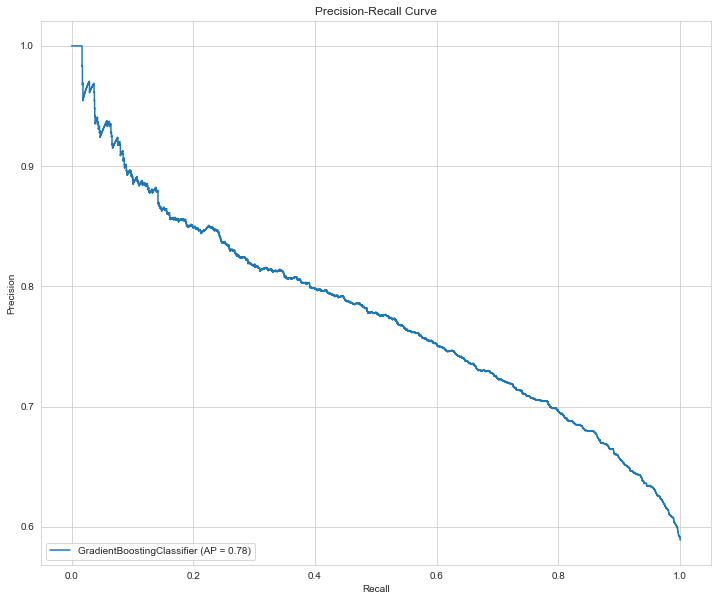

In [6]:
# plot and save precision-recall curve
fig, ax = plt.subplots(figsize=(12,10))
_ = plot_precision_recall_curve(model, X_test, y_test, ax=ax)
_ = plt.title("Precision-Recall Curve")
_ = plt.savefig("precision_recall.png")

In [7]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

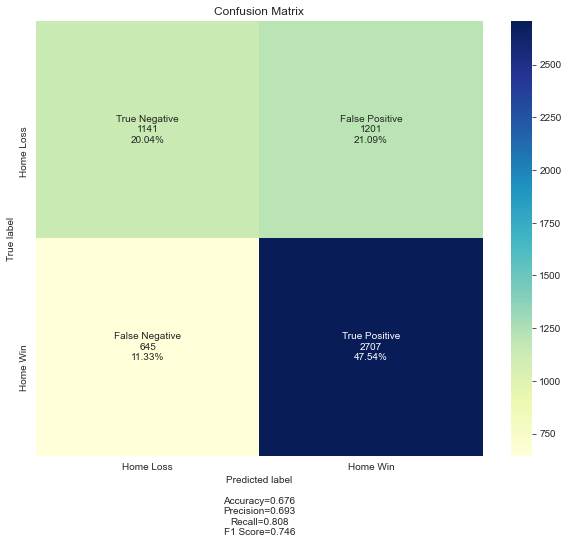

In [8]:
# make and save confusion matrix
cf_matrix = confusion_matrix(y_test,y_pred)


make_confusion_matrix(cf_matrix,
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Home Loss','Home Win'],
                      figsize=(10,8),
                      cmap='YlGnBu',
                      title="Confusion Matrix")

plt.savefig("confusion_matrix.png")

## Conclusion

The model performs fairly well. With an accuracy of ~67%, this is an improvement over expert consensus NBA game picks, which clock in at 59%. This represents about an 11% improvement in relative performance (7% overall).

I would be interested in trying to create a model with a lower FP rate, although this can be difficult with an imbalanced data set (home teams win 59% of their games).